In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 




import json



In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
model_conf = confs.bert_conf
encoding_type = 'relative'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_bert_about_rel'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.49489795918367346
MALE 0.9453125
FEMALE 0.0625 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.5164141414141414
MALE 0.9440389294403893
FEMALE 0.05511811023622047 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.5202086049543677
MALE 0.9267676767676768
FEMALE 0.0862533692722372 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6812034288765246 	 Validation loss: 0.6779673847101503 	 
  1%|          | 574/57400 [01:35<2:34:33,  6.13it/s]
Epoch 2 	 Training loss: 0.6714254414162985 	 Validation loss: 0.6653873142549547 	 
  2%|▏         | 1148/57400 [03:03<2:12:31,  7.07it/s]
Epoch 3 	 Training loss: 0.6502908099611462 	 Validation loss: 0.6271094235323244 	 
  3%|▎         | 1722/57400 [04:39<2:38:19,  5.86it/s]
Epoch 4 	 Training loss: 0.5848708332415657 	 Validation loss: 0.5289282238079329 	 
  4%|▍         | 2296/57400 [06:16<2:18:51,  6.61it/s]
Epoch 5 	 Training loss: 0.49093486218086935 	 Validation loss: 0.4439104861122067 	 
  5%|▌         | 2870/57400 [07:53<2:32:38,  5.95it/s]
Epoch 6 	 Training loss: 0.43242039814435645 	 Validation loss: 0.4025177475759539 	 
  6%|▌         | 3444/57400 [09:30<2:28:17,  6.06it/s]
Epoch 7 	 Training loss: 0.4035016942626508 	 Validation loss: 0.38012119369991754 	 
  7%|▋         | 4018/57400 [11:07<2:21:47,  6.27it/s]
Epoch 8 	 Training

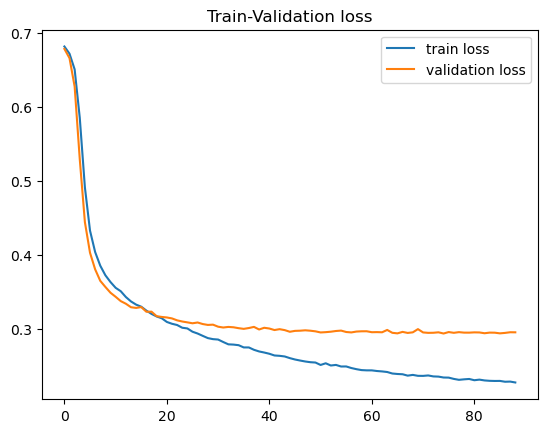

In [17]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.8571428571428571
MALE 0.8697916666666666
FEMALE 0.845 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6830808080808081
MALE 0.6958637469586375
FEMALE 0.6692913385826772 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6831812255541069
MALE 0.702020202020202
FEMALE 0.6630727762803235 



# TO

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_bert_to_rel'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6970976978436579 	 Validation loss: 0.6921285966695365 	 
  1%|          | 574/57400 [01:30<2:33:55,  6.15it/s]
Epoch 2 	 Training loss: 0.6952031033587373 	 Validation loss: 0.6930658049502615 	 
  2%|▏         | 1148/57400 [03:01<2:27:01,  6.38it/s]
Epoch 3 	 Training loss: 0.6946423924966141 	 Validation loss: 0.6932257626016262 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [04:31<2:25:11,  6.39it/s]
Epoch 4 	 Training loss: 0.694419562089734 	 Validation loss: 0.6927058312852504 	 
  4%|▍         | 2296/57400 [06:02<2:17:45,  6.67it/s]
Epoch 5 	 Training loss: 0.6948011670170761 	 Validation loss: 0.6924761493327254 	 
  5%|▌         | 2870/57400 [07:32<2:25:25,  6.25it/s]
Epoch 6 	 Training loss: 0.6937913769005898 	 Validation loss: 0.6927009760323217 	 
  6%|▌         | 3444/57400 [09:03<2:18:14,  6.51it/s]
Epoch 7 	 Training loss: 0.6941237869163008 	 Validation loss: 0.6927896263235707 	 
  7%|▋         | 4018/57400 [10:33<2:19:52,  6.3

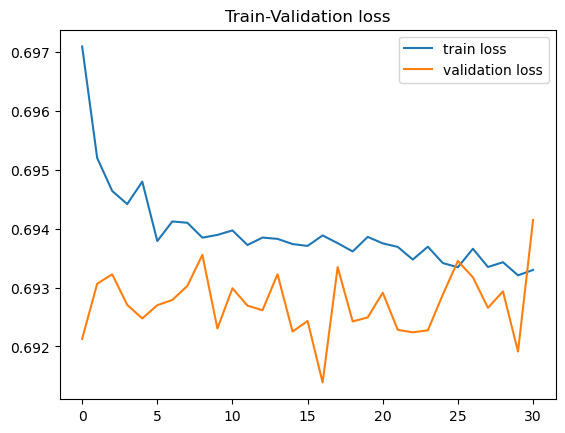

In [20]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.42346938775510207
MALE 0.20833333333333334
FEMALE 0.63 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.4671717171717172
MALE 0.2822384428223844
FEMALE 0.6666666666666666 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.4758800521512386
MALE 0.29545454545454547
FEMALE 0.6684636118598383 



# AS

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_bert_as_rel'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6952176867669467 	 Validation loss: 0.6928464841034453 	 
  1%|          | 574/57400 [01:30<2:25:38,  6.50it/s]
Epoch 2 	 Training loss: 0.6948801173150332 	 Validation loss: 0.6926758723743891 	 
  2%|▏         | 1148/57400 [03:01<2:29:20,  6.28it/s]
Epoch 3 	 Training loss: 0.6944378800300771 	 Validation loss: 0.6929055715011339 	 
  3%|▎         | 1722/57400 [04:32<2:23:06,  6.48it/s]
Epoch 4 	 Training loss: 0.6941467093673732 	 Validation loss: 0.6935819660202932 	 
  4%|▍         | 2296/57400 [06:02<2:20:56,  6.52it/s]
Epoch 5 	 Training loss: 0.6939274542007712 	 Validation loss: 0.6930953567310915 	 
  5%|▌         | 2870/57400 [07:33<2:25:16,  6.26it/s]
Epoch 6 	 Training loss: 0.6940410251401443 	 Validation loss: 0.6919830320245128 	 
  6%|▌         | 3444/57400 [09:03<2:13:17,  6.75it/s]
Epoch 7 	 Training loss: 0.6935986441394594 	 Validation loss: 0.6926869497460834 	 
  7%|▋         | 4018/57400 [10:34<2:15:45,  6.55it/s]
Epoch 8 	 Training lo

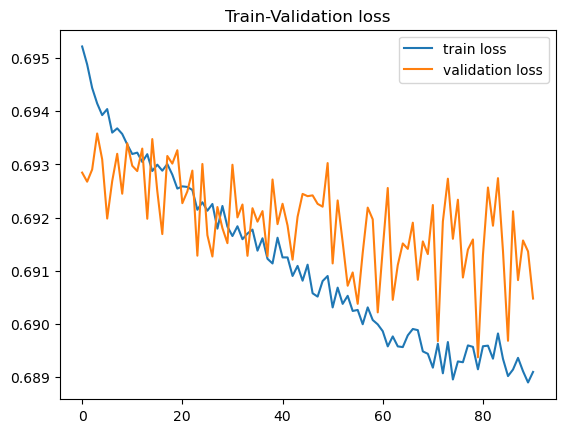

In [23]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [24]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.701530612244898
MALE 0.71875
FEMALE 0.685 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6388888888888888
MALE 0.6642335766423357
FEMALE 0.6115485564304461 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6558018252933507
MALE 0.6237373737373737
FEMALE 0.6900269541778976 

